## Part 1: RNN Example

(10 points)

In this example we train an RNN to infer the parameters of a simple dynamical system.
First, we simulate a dynamical system with known parameters (random numbers), and use it to generate outputs. Then, we train an RNN on the generated datapoints, attempting to infer the original parameters.
You are expected to run and study the provided code, which will be helpful for the second part (implementing LSTM).

1. We define a discretized [dynamical system](https://en.wikipedia.org/wiki/Dynamical_system).
At each discrete time $t$, the system observes input $x_t$. The system maintains some "state" $h_t$, which will be updated over time.
Specifically, the states are updated by the following rule: $h_t = \max(0, 1-(Wx_t+h_{t-1}))$, where $W$ is a parameter matrix.
2. In this example, the input data $\{x_t\}$ is randomly generated, and the weight matrix $W$ is also drawn randomly. The system starts from an initial hidden state $h_0$, and runs for $t=1,\ldots,T$.
3. Given the sequence of states $\{h_1,\ldots,h_T\}$, we would like to infer the weights $W$.

To start with, the following code segment generates and displays the data.
Refer to `data_generator.py` for details of data generation.

variable name, shape, min, max: 
h0 (10,) -0.227338038799 2.18803183795
w (10, 10) -3.15093751889 1.95340496211
x (100, 10) -3.15554537384 3.36526071537


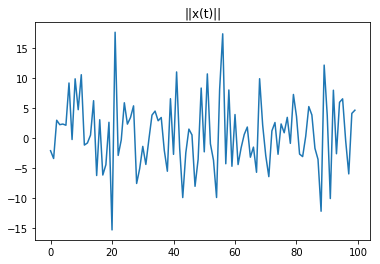

In [1]:
# Here we present sample data generated 
import numpy as np
import data_generator
import matplotlib.pyplot as plt

(h_0, w), x, h = data_generator._build_rnn_testdata_matrix()

print('variable name, shape, min, max: ')
for v, name in zip([h_0, w, x], ['h0', 'w', 'x']):
    print(name, v.shape, np.min(v), np.max(v))
norm_x_t = np.sum(x*2, axis=1)
plt.title('||x(t)||')
plt.plot(np.arange(norm_x_t.shape[0]), norm_x_t)
plt.show()

We model the dynamical system with an RNN. We would like the state generated by the RNN to match the actual observed, and we use L2 loss for this purpose.
This RNN is a *regression* model since it outputs real values.

Below, `build_rnn_regression_model()` gives the model definition, and `train_rnn_with_noise()` generates a batch of data and then runs training on it. 
We corrupt the data generation process with noise, and let the dimensionality of the state $h$ be a free parameter. Therefore, the training function takes two input arguments: `noise_level` and `n_hidden_dim`.   You will later see how varying them affects reconstruction quality.

In [2]:
import datetime
import os
import numpy as np
import tensorflow as tf
import data_generator
from __future__ import print_function

#############################################################################
# RNN model graph
def build_rnn_regression_model(shape):
    # shape is dict with keys:
    # n_steps_per_batch, n_hidden_dim, n_input_dim
    with tf.Graph().as_default() as g:
        # inputs to the dynamical system
        X = tf.placeholder(tf.float32,
                           [None, shape['n_steps_per_batch'], shape['n_input_dim']])
        # observed state from the dynamical system
        y = tf.placeholder(tf.float32, [None, shape['n_hidden_dim']])
        
        with tf.variable_scope('weights'):
            # weight matrix
            w = tf.get_variable('w', [shape['n_input_dim'], shape['n_hidden_dim']])
            # initial state
            h_0 = tf.get_variable('h_0', [shape['n_hidden_dim']])
            
        # for t = 1 to T, update state 
        h_t = h_0
        for t in range(shape['n_steps_per_batch']):
            x_t = X[:, t, :] #x_t.shape = [Batch_size,n_input]
            h_t = tf.maximum(0.0, 1 - (tf.matmul(x_t, w) + h_t))
        
        # loss: L2
        loss = tf.nn.l2_loss(h_t - y, name='loss') #L2 loss is mean square error loss
        train_op = tf.train.AdamOptimizer(0.1).minimize(loss)
        summ = tf.summary.scalar('loss_sum_%dd' % shape['n_hidden_dim'], loss)# tf.summary.scalar(name,tensor), name='loss_sum_(num of hidden unit)'
        
    return {'inputs': [X, y], 'loss': loss, 'train_op': train_op, 'summ': summ,
            'weights': {'w': w, 'h_0': h_0}, 'graph': g}

#############################################################################
# Main train loop for an RNN regression model
# 
# This takes synthetic data generated by data_generator.build_dataset()
# the weight matrix W is then inferred with back-prop 
def train_rnn_with_noise(noise_level, n_hidden_dim):
    
    # generate data
    shapes = dict(n_hidden_dim=n_hidden_dim, n_input_dim=15, n_steps_per_batch=100)
    rnn_dataset = data_generator.build_dataset('rnn', noise=noise_level, **shapes)# **shapes(or **anything): add a dict to dunction instad of feeding each argument for a function 
    (h0_true, w_true), batched_data = rnn_dataset  # "true" weights
    # batched_data = data 
    
    # build RNN model
    model = build_rnn_regression_model(shapes)
    
    #logdir = './tensorboard/rnn_demo'  # if on Windows
    #logdir = '/tmp/tensorboard/rnn_demo'  # if on Unix
    logdir = 'summary_q1'
    try:
        os.makedirs(logdir)
    except os.error:
        pass
    # If you want to see the plots, run tensorboard:
    # $ tensorboard --logdir=[your_logdir]
    #
    # If you use SCC, you can forward the 6006 port from the cluster 
    # to your local machine via:
    # $ ssh [SCC_cluster_name] -L 6006:localhost:6006
    time_now = datetime.datetime.now().strftime("%d-%b-%H-%M-%S")
    run_name = 'hidden=%d_noise=%.2f' % (n_hidden_dim, noise_level)
    sum_path = os.path.join(logdir, run_name + '_' + time_now)
    print(sum_path)
    max_iter_i = 0
    with model['graph'].as_default() as g, tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sum_writer = tf.summary.FileWriter(sum_path, g)
        for epoch_i in range(50):
            loss_val, w_dist, h0_dist, iter_i = None, None, None, None
            for iter_i, data_batch in enumerate(batched_data):#iter_i = n_batch, data_batch = each batch from n batches
                max_iter_i = max(iter_i, max_iter_i)
                global_step = epoch_i*max_iter_i+iter_i
                
                # run training step
                train_feed_dict = dict(zip(model['inputs'], data_batch))
                to_compute = [model['train_op'], model['summ'], model['loss'],
                              model['weights']['w'], model['weights']['h_0']]
                _, summ, loss_val, w_val, h0_val = sess.run(to_compute, train_feed_dict)
                
                # compute reconstruction error
                w_err = np.linalg.norm(w_true-w_val)#L2 norm
                h0_err = np.linalg.norm(h0_true-h0_val)
                
                # for tensorboard
                sum_writer.add_summary(summ, global_step) #add_summary(summary or merged_summary , steps)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="w_true_dist_%dd" % n_hidden_dim,
                                     simple_value=w_err),
                ]), global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="h_true_dist_%dd" % n_hidden_dim,
                                     simple_value=h0_err),
                ]), global_step)
                sum_writer.flush()#Call this method to make sure that all pending events have been written to disk
                
            print('epoch %d, loss=%g, w_err=%g'%(epoch_i, loss_val, w_err))
            if global_step > 200: 
                break  # just train for 200 iterations

### Q1.
Now test the RNN wth varying noise levels and hidden dimensionalities.
- For each combination of `n_hidden_dim` and `noise_level`, report the reconstruction error (`w_err`).
- Describe how the hidden dimentionality and the noise level influence reconstruction quality. And briefly explain why.

In [3]:
# Experimenting with different data noise levels and hidden dimentionalities
# We are lucky to know the true hidden dimentionality in our simultaion
for n_hidden_dim in [10, 100, 1000]:
    for noise_level in [0, 0.1, 0.5]:
        print('n_hidden_dim %d, noise_level %g' %(n_hidden_dim, noise_level))
        train_rnn_with_noise(noise_level, n_hidden_dim)

n_hidden_dim 10, noise_level 0
summary_q1/hidden=10_noise=0.00_24-Apr-20-35-14


/home/drew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:97: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/home/drew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:101: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


epoch 0, loss=21.7464, w_err=2.27913
epoch 1, loss=3.99693, w_err=0.821635
epoch 2, loss=0.354323, w_err=0.249358
epoch 3, loss=0.0353669, w_err=0.0978636
epoch 4, loss=0.00661691, w_err=0.0500684
epoch 5, loss=0.00157082, w_err=0.027675
epoch 6, loss=0.000779871, w_err=0.0164796
epoch 7, loss=0.000385589, w_err=0.0118495
n_hidden_dim 10, noise_level 0.1
summary_q1/hidden=10_noise=0.10_24-Apr-20-35-21
epoch 0, loss=24.9035, w_err=1.96231
epoch 1, loss=4.53444, w_err=0.94774
epoch 2, loss=3.71061, w_err=0.591558
epoch 3, loss=3.01951, w_err=0.586475
epoch 4, loss=3.31639, w_err=0.614331
epoch 5, loss=3.51989, w_err=0.650146
epoch 6, loss=3.78551, w_err=0.684975
epoch 7, loss=4.2381, w_err=0.748548
n_hidden_dim 10, noise_level 0.5
summary_q1/hidden=10_noise=0.50_24-Apr-20-35-27
epoch 0, loss=62.5404, w_err=3.47266
epoch 1, loss=36.4709, w_err=2.40816
epoch 2, loss=39.8779, w_err=2.45214
epoch 3, loss=42.4082, w_err=2.37396
epoch 4, loss=43.6137, w_err=2.40301
epoch 5, loss=43.7377, w_err

**Answer_Q1 :** 


|n_idden_dim| noise_level|w_err|
|--|--|-----------------------------|
| 10 | 0 |0.01185 |
| 10 | 0.1 |0.748548 |
| 10 | 0.5 |2.48808|
| 100 | 0 |0.0910307 |
| 100 | 0.1 |1.90559 |
| 100 | 0.5 |6.40752 |
| 1000 | 0 |0.315282|
| 1000 | 0.1 |5.45291 |
| 1000 | 0.5 |19.5273|

It is obvoius that when we add noise, the error would be increased. So as we see the results, when we add noise and increse its level we get higher error.
And also, from the table, when we increse number of hidden dim, the error is going to increase because when we number of hidden units are more then the size of matrix W increases so we have more elements to compute loss so our error increases as well. 


## Part 2: LSTM implementation

(40 points)

Now let's attempt to recover the weights in dynamical system simulated with an LSTM.  Although LSTMs are already implemented in TensorFlow ([tutorial here](https://www.tensorflow.org/tutorials/recurrent)) ([source here](https://github.com/tensorflow/tensorflow/blob/efe5376f3dec8fcc2bf3299a4ff4df6ad3591c88/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L264)), you will be implementing a simple LSTM from scratch using Tensorflow in this part. 


### Q2. Implement an LSTM 
Implement an LSTM model in an analogous way,  in functions `build_lstm_regression_model()` and `train_lstm_with_noise()` below.
The RNN regression implementation above should give you some ideas.
We already provided an LSTM version of the dynamical system generator in the dataset generator code.

- Specifically, you can follow and implement Eq. 1-6 from [this link](http://deeplearning.net/tutorial/lstm.html) in `build_lstm_regression_model()`. 
You may simplify your code by concatenating $x$ and $h$.
- Afterwards, implement `train_lstm_with_noise()` to train the LSTM and recover the parameters. Compute the reconstruction errors for $W_c$ and $U_c$, which are the parameters used in Eq. 2 in the link.
- For each combination of hidden dimension and noise level, report the reconstruction error (`w_err`, `u_err`) you get from the LSTM.

Note:
- The weights might not get reconstructed correctly in the LSTM case even without noise. (Why?)
Nevertheless, the loss should decrease.

In [5]:
def build_lstm_regression_model(shape):
    # shape is dict with keys:
    # n_steps_per_batch, n_hidden_dim, n_input_dim
    with tf.Graph().as_default() as g:
        # inputs
        X = tf.placeholder(tf.float32,
                           [None, shape['n_steps_per_batch'], shape['n_input_dim']])
        # observed outputs
        y = tf.placeholder(tf.float32, [None, shape['n_hidden_dim']])
        
        ####################  PUT YOUR CODE HERE   ######################
      
        with tf.variable_scope('weights'):
            
            w_i = tf.get_variable('W_i', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_f = tf.get_variable('W_f', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_c = tf.get_variable('W_c', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_o = tf.get_variable('W_o', [shape['n_input_dim'], shape['n_hidden_dim']])
            
            u_i = tf.get_variable('U_i', [shape['n_hidden_dim'] , shape['n_hidden_dim']])
            u_f = tf.get_variable('U_f', [shape['n_hidden_dim'] , shape['n_hidden_dim']])
            u_c = tf.get_variable('U_c', [shape['n_hidden_dim'] , shape['n_hidden_dim']])
            u_o = tf.get_variable('U_o', [shape['n_hidden_dim'] , shape['n_hidden_dim']])
            
            v_o = tf.get_variable('V_o', [shape['n_hidden_dim'] , shape['n_hidden_dim']])
            
            h_0 = tf.get_variable('h_0', [1,shape['n_hidden_dim']])
            c_0 = tf.get_variable('c_0' , [1,shape['n_hidden_dim']])
            
            c_t = c_0
            h_t = h_0
            for t in range(shape['n_steps_per_batch']):
                x_t = X[:,t,:]
                i_t = tf.nn.sigmoid(tf.matmul(x_t,w_i) + tf.matmul (h_t,u_i))
                c_bar_t = tf.nn.tanh(tf.matmul(x_t,w_c) + tf.matmul (h_t,u_c))
                f_t = tf.nn.sigmoid(tf.matmul(x_t,w_f) + tf.matmul (h_t,u_f))
                c_t = tf.multiply(i_t,c_bar_t) + tf.multiply(f_t,c_t)
                o_t = tf.nn.sigmoid(tf.matmul(x_t,w_o) + tf.matmul (h_t,u_o) + tf.matmul(c_t,v_o))
                h_t = tf.multiply(o_t,tf.tanh(c_t))   
            
        
        output = h_t  # put your result in variable 'output'
        
        #################################################################
        # loss and train_op
        loss = tf.nn.l2_loss(output - y, name='loss')
        train_op = tf.train.AdamOptimizer().minimize(loss)
        summ = tf.summary.scalar('loss_sum_%dd' % shape['n_hidden_dim'], loss)

    return {'inputs': [X, y], 'loss': loss, 'train_op': train_op, 'summ': summ,
            'weights': {'w_c': w_c, 'u_c': u_c}, 
            'graph': g} # we just return w_c and u_c cause they are "true weights" to recover
    
    
def train_lstm_with_noise(noise_level, n_hidden_dim):
    # generate data and random weights
    shapes = dict(n_hidden_dim=n_hidden_dim, n_input_dim=15, n_steps_per_batch=100)
    weights, batched_data = data_generator.build_dataset('lstm', noise=noise_level, **shapes)
    w_c, u_c = weights[3], weights[7]  # the "true" weights to recover: Wc & Uc (in Eq.2)
    
    # this is the function you implemented
    model = build_lstm_regression_model(shapes)
    
    #logdir = './tensorboard/lstm_demo'  # if on Windows
    logdir = '/tmp/tensorboard/lstm_demo'  # if on Unix
    try:
        os.makedirs(logdir)
    except os.error:
        pass
    time_now = datetime.datetime.now().strftime("%d-%b-%H-%M-%S")
    run_name = 'hidden=%d_noise=%.2f' % (n_hidden_dim, noise_level)
    sum_path = os.path.join(logdir, run_name + '_' + time_now)
    print(sum_path)
    
    max_iter_i = 0
    with model['graph'].as_default() as g, tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sum_writer = tf.summary.FileWriter(sum_path, g)
        for epoch_i in range(25):  # **********
            loss_val, w_err, u_err, iter_i = None, None, None, None
            for iter_i, data_batch in enumerate(batched_data):
                max_iter_i = max(iter_i, max_iter_i)
                global_step = epoch_i*max_iter_i+iter_i
                
                ###############################################################
                ###################   PUT YOUR CODE HERE   ####################
                train_feed_dict = dict(zip(model['inputs'],data_batch))
                to_compute = [model['train_op'], model['summ'], model['loss'],
                              model['weights']['w_c'], model['weights']['u_c']]
                _, summ, loss_val, w_c_val, u_c_val = sess.run(to_compute, train_feed_dict)
                w_err = np.linalg.norm(w_c - w_c_val)  # compute them and report
                u_err = np.linalg.norm(u_c - u_c_val)
                sum_writer.add_summary(summ, global_step) #add_summary(summary or merged_summary , steps)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="w_true_%dd" % n_hidden_dim,
                                      simple_value=w_err), #**** Look the rnn
                ]), global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="u_true_%dd" % n_hidden_dim,
                                     simple_value=u_err),
                ]), global_step)
                sum_writer.flush()#Call this method to make sure that all pending events have been written to disk
                
            print('epoch %d, loss=%g, w_err=%g, u_err=%g'%(epoch_i, loss_val, w_err, u_err))
            #if global_step > 300: 
                #break  

In [6]:
for n_hidden_dim in [10, 100, 1000]:
    for noise_level in [0, 0.1, 0.5]:
        print(n_hidden_dim, noise_level)
        train_lstm_with_noise(noise_level, n_hidden_dim)

10 0
/tmp/tensorboard/lstm_demo/hidden=10_noise=0.00_24-Apr-20-37-20


/home/drew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:96: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/home/drew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:100: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


epoch 0, loss=19.415, w_err=13.7813, u_err=10.8849
epoch 1, loss=18.6685, w_err=13.6967, u_err=10.889
epoch 2, loss=18.0439, w_err=13.6129, u_err=10.8935
epoch 3, loss=17.5041, w_err=13.5301, u_err=10.8977
epoch 4, loss=17.0241, w_err=13.4485, u_err=10.9012
epoch 5, loss=16.5875, w_err=13.3683, u_err=10.9038
epoch 6, loss=16.1836, w_err=13.2897, u_err=10.9055
epoch 7, loss=15.805, w_err=13.2129, u_err=10.906
epoch 8, loss=15.4464, w_err=13.1378, u_err=10.9054
epoch 9, loss=15.1039, w_err=13.0646, u_err=10.9037
epoch 10, loss=14.7749, w_err=12.9932, u_err=10.9008
epoch 11, loss=14.4576, w_err=12.9236, u_err=10.8967
epoch 12, loss=14.1509, w_err=12.8558, u_err=10.8912
epoch 13, loss=13.8536, w_err=12.7898, u_err=10.8843
epoch 14, loss=13.5654, w_err=12.7256, u_err=10.8761
epoch 15, loss=13.2858, w_err=12.6631, u_err=10.8663
epoch 16, loss=13.0149, w_err=12.6025, u_err=10.8552
epoch 17, loss=12.7527, w_err=12.5436, u_err=10.8427
epoch 18, loss=12.4998, w_err=12.4865, u_err=10.8289
epoch 1

Q2.Answer


|n_idden_dim| noise_level|w_err|u_err
|--|--|-----------------------------|
| 10 | 0 |12.1786|10.7286|
| 10 | 0.1 |9.64862|10.4432|
| 10 | 0.5 |9.98396|11.8258|
| 100 | 0 |37.0384 |100.307
| 100 | 0.1 |35.5472|100.4|
| 100 | 0.5 |35.7513 |100.878|
| 1000 | 0 |121.528|1000.54|
| 1000 | 0.1 |121.181 |999.543
| 1000 | 0.5 |121.3|999.403|

As you see from the table, even in the cases that we do not have any noise, loss is decreasing but errors increase. This is because in learning process, we just decrease loss (in gradient method) we do not do anything for decreasing weights. SO we can conclude that there exists another weights that can decrease after some iteration as well as decreasing loss. 

## Part 4: Multi-modal Restricted Boltzmann Machines

(30 points)

- Relevant reading: Goodfellow chapter 20 through 20.8, in particular 20.2 and 20.3. Also see the [lecture notes](https://drive.google.com/file/d/0B8xkaMshuaF9dFVRclo3RENKdUk/view?usp=sharing).

For this question, we will consider designing an unsupervised probability distribution  over two modalities.  Suppose we have data consisting of images and their associated captions, so that each input data point may be thought of as the pair $(t,v)$, where $t = (t_1, ..., t_n)$ is the text data and $v = (v_1, ..., v_m)$ is the visual data.  For simplicity, we will consider both as vector inputs (so, for instance, we will not be considering any two-dimensional convolutions for the visual data); the main difference between the two inputs is that the text input is discrete-valued, where we assume that each $t_i$ can take on $k$ different values, and each visual input is real-valued.

Following our discussion of Restricted Boltzmann Machines (RBMs), we will further consider a hidden layer with **binary** hidden units $(h_1, ..., h_d)$, and define a joint probability distribution over an input data point and a hidden layer.  In particular, let us define two matrices $W_t\in\mathbb{R}^{n\times d}$ and $W_v\in\mathbb{R}^{m\times d}$; these matrices correspond to weights between text input and hidden units, and weights between visual input and hidden units, respectively.  In addition, we have the bias vectors $a$, $b$, and $c$, associated with the text, visual, and hidden units, respectively.
The multi-modal RBM is illustrated below.

<img src="MultimodalRBM.png" width="550">

Next we define the joint probability distribution $p(t,v,h)$ over text inputs, visual inputs, and hidden states.  First we let the energy function be: 

$E(v,t,h) = -t^T W_t h - v^T W_v h - a^T t + (0.5 t^Tt - b^T v + 0.5 v^T v) - c^T h$.

Then let the joint probability be defined as:

$p(v,t,h) = \frac{1}{Z}exp(-E(v,t,h)),$

where $Z$ is the normalizing constant that ensures that the probability distribution is properly normalized to sum/integrate to one.

Our goal is to perform maximum likelihood estimation for the parameters $W_t$, $W_v$, and $c$ (we will assume $a$ and $b$ are fixed and known), given a set of $N$ data points $D = \{(t^{(1)},v^{(1)}), ..., (t^{(N)},v^{(N)})\}$.  As is typical in such settings, we assume that the data in $D$ are i.i.d. samples.

Please write your solutions in the cells below, or hand in a hard copy.
For each question you must show your work to receive full credit.

### Q4.1 

Write down the marginal probability for a single data point $(t^{(1)}, v^{(1)})$, namely $p(t^{(1)}, v^{(1)})$. Treating this probability as the likelihood for a single point, write down the log-likelihood for the entire data set $D$ as a function of the parameters $(W_t, W_v,  c)$.

**Answer**

$$p(t^{(1)}, v^{(1)}) = \frac{1}{Z}exp(-E(v,t,h)) = \sum_h p(t^{(1)}, v^{(1)},h) = $$
$$\sum_h \frac{1}{Z}exp[{t^{(1)}}^T W_t h + {v^{(1)}}^T W_v h + a^T t^{(1)} - 0.5 {t^{(1)}}^Tt^{(1)} + b^Tv^{(1)} - 0.5 {v^{(1)}}^T v^{(1)} + c^T h]$$

For all data: $$ \mathcal L(W_t,W_v,c | D) = \prod_{i}^{N} p(t^{(i)}, v^{(i)}) $$
Log liklihood: $$ \log (L(W_t,W_v,c|D)) = \sum_{i}^{N} \log (\sum_h \frac{1}{Z}exp[{t^{(i)}}^T W_t h + {v^{(i)}}^T W_v h + a^T t^{(i)} - 0.5 {t^{(i)}}^Tt^{(i)} + b^Tv^{(i)} - 0.5 {v^{(i)}}^T v^{(i)} + c^T h]) =$$
$$ -N \log(Z) + \sum_{i}^{N}\log (\sum_h \frac{1}{Z}exp[{t^{(i)}}^T W_t h + {v^{(i)}}^T W_v h + a^T t^{(i)} - 0.5 {t^{(i)}}^Tt^{(i)} + b^Tv^{(i)} - 0.5 {v^{(i)}}^T v^{(i)} + c^T h]) $$
We know that : $$ Z = \sum_t \sum_v \sum_h exp(-E(v,t,h)) \rightarrow -N \log Z = -N \log(\sum_{t,v,h}exp(-E(v,t,h))) $$
So now we have: 
$$   \log (L(W_t,W_v,c|D)) =-N \log(\sum_{t,v,h}exp(t^T W_t h + v^T W_v h + a^T t - (0.5 t^Tt - b^T v + 0.5 v^T v) + c^T h)) +  
\sum_{i}^{N}\log {(\sum_hexp[{t^{(i)}}^T W_t h + {v^{(i)}}^T W_v h + a^T t^{(i)} - 0.5 {t^{(i)}}^Tt^{(i)} + b^Tv^{(i)} + 0.5 {v^{(i)}}^T v^{(i)} - c^T h])} $$

### Q4.2 

Write down the partial derivative of $E(t,v,h)$ with respect to each of the parameters, i.e., each entry of $W_t$, each entry of $W_v$, and each entry of $c$. You can also directly write in matrix/vector forms.


**Answer**
$$ \frac{\partial E(v,t,h)}{\partial W_t }  = -t\ h^{T} $$

$$ \frac{\partial E(v,t,h)}{\partial W_v} = -v\ h^{T} $$

$$ \frac{\partial E(v,t,h)}{\partial c} = - h^{T}  $$

### Q4.3 

Derive the conditional distributions $p(h | v, t)$, $p(v | h)$ and $p(t | h)$, either in elementwise form or in vector form.
Also establish that $v$ and $t$ are conditionally independent given $h$.

**Answer**

$$ p(h | v, t) = \frac{p(h , v, t) }{p(v, t)}= \frac{\frac{1}{Z} exp(-E(h,v,t))}{p(v,t)} =\frac{ \frac{1}{Z}exp(t^T W_t h + v^T W_v h + a^T t - (0.5 t^Tt - b^T v + 0.5 v^T v) - c^T h)}{p(v,t)}=$$

$$ \frac{1}{Z'}exp(t^T W_t h + v^T W_v h + c^T h) =  \frac{1}{Z'}exp(\sum_{j=1}^{d}t^T W_{t_{:,j}} h_j + \sum_{j=1}^{d}v^T W_{v_{:,j}} h_j + \sum_{j=1}^{d}c_j h_j) = \frac{1}{Z'} \prod_{j=1}^{d}exp({t^T W_{t_{:,j}} h_j + v^T W_{v_{:,j}} h_j + c_j h_j}) $$

So we can factorize conditional probability over $h_j$:
$$ p(h_j=1 | v, t) = \frac{exp(t^T W_{t_{:,j}} + v^T W_{v_{:,j}} + c_j)}{exp(0)+exp(t^T W_{t_{:,j}} + v^T W_{v_{:,j}} + c_j)}  = \sigma(t^T W_{t_{:,j}} + v^T W_{v_{:,j}} + c_j)$$
Now, we would have:
$$ p(h |  v, t) = \prod_{j=1}^{d} \sigma\big((2h-1)\odot (t^T W_t + v^T W_v + c)\big)_j $$

For $p(v,t|h):$

$$p(v,t | h) = \frac{p(h , v, t) }{p(h)} = \frac{\frac{1}{Z} exp(-E(h,v,t))}{p(h)} = \frac{ \frac{1}{Z}exp(t^T W_t h + v^T W_v h + a^T t - (0.5 t^Tt - b^T v + 0.5 v^T v) - c^T h)}{p(v,t)}=$$

$$ \frac{1}{Z'}exp(a^T t - 0.5 t^Tt + b^T v - 0.5 v^T v) = \frac{1}{Z'}exp(a^T t - 0.5 t^Tt)exp(b^T v - 0.5 v^T v) \  \propto p(t|h)p(v|h)$$

Then we can factorize $p(v|h)$ and $p(t|h)$ as following: 
 
$$p(v_j|h) = \frac{1}{Z'} \prod_{j=1}^{m}exp(v_j W_{v_{:,j}} h + b_j v_j   -  0.5 v_j^2) =\sigma((2v_j-1)(v_j W_{v_{:,j}} h + b_j v_j   -  0.5 v_j^2) ) $$
Then $$ p(v | h) = \prod_{j=1}^{m} \sigma\big((2v-1)\odot (W_v h + b^T + 0.5v)\big)_j  $$
Similarly:
$$ p(t_j|h) = \sigma \big((2t_j-1)(t_j W_{t_{:,j}} h + a_j t_j   -  0.5 t_j^2) \big)  $$

$$ p(t | h) = \prod_{j=1}^{n} \sigma\big((2t-1)\odot (W_t h + a^T + 0.5t)\big)_j  $$


### Q4.4

Write down the partial derivative of the log-likelihood for $D$ with respect to each of the parameters.

**Answer**

$$\frac{\partial L(W_t,W_v,c | D)}{\partial W_t }  = -N \frac{\partial}{\partial W_t } \log(\sum_{h,v,t} exp(-E(v,t,h))) + \frac{\partial}{\partial W_t }\sum_{i=1}^N \ log \sum_h exp(-E(v^{(i)},t^{(i)},h)) $$
First term:

$$ -N \frac{\partial}{\partial W_t } \log(\sum_{h,v,t} exp(-E(v,t,h))) = \frac{-N}{\sum_{h,v,t} exp(-E(v,t,h))} \frac{\partial}{\partial W_t }\sum_{h,v,t} exp(-E(v,t,h)) =$$

$$\frac{N}{\sum_{h,v,t} exp(-E(v,t,h))} \sum_{h,v,t} exp(-E(v,t,h))\frac{\partial E(v,t,h)}{\partial W_t } = \frac{-N}{\sum_{h,v,t} exp(-E(v,t,h))} \sum_{h,v,t} exp(-E(v,t,h))\ t\  h^T  $$

From the definiton of $p(t,v,h):$

$$= -N  \sum_{h,v,t} p(v,t,h)\ t\  h^T = -N\  E_{Model}[th^T]$$

The second term: 

$$\frac{\partial}{\partial W_t }\sum_{i=1}^N \ log \sum_h exp(-E(v^{(i)},t^{(i)},h)) = \sum_{i=1}^N \frac{\partial}{\partial W_t } \log \sum_h  exp(-E(v^{(i)},t^{(i)},h)) =  $$

$$= \sum_{i=1}^N \frac{-1}{\sum_h  exp(-E(v^{(i)},t^{(i)},h))}\sum_h exp(-E(v^{(i)},t^{(i)},h))\frac{\partial}{\partial W_t }E(v^{(i)},t^{(i)},h) =\sum_{i=1}^N \sum_h \frac{exp(-E(v^{(i)},t^{(i)},h))}{\sum_h  exp(-E(v^{(i)},t^{(i)},h))} t^{(i)} h^T$$

$$= \sum_{i=1}^N \sum_h p(h|t^i,v^i) \ t\  h^T =  NE_{Data}[t h^T]$$ 

$$\frac{\partial L(W_t,W_v,c | D)}{\partial W_t }  = N(E_{Data}[th^T]- E_{model}[th^T]) $$

Similarly we have done the same approach for $\frac {\partial L(W_t,W_v,c | D)}{\partial W_v }$:

$$ \frac{\partial L(W_t,W_v,c | D)}{\partial W_v }  = N (E_{Data}[vh^T] -E_{model}[vh^T]) $$

And for $\frac {\partial L(W_t,W_v,c | D)}{\partial c }$:


$$\frac{\partial L(W_t,W_v,c | D) }{\partial c }= -N \frac{\partial}{\partial c } \log(\sum_{h,v,t} exp(-E(v,t,h))) + \frac{\partial}{\partial c }\sum_{i=1}^N \ log \sum_h exp(-E(v^{(i)},t^{(i)},h))$$

For the first term: 

$$-N \frac{\partial}{\partial c } \log(\sum_{h,v,t} exp(-E(v,t,h))) = \frac{-N}{\sum_{h,v,t} exp(-E(v,t,h))} \frac{\partial}{\partial c }\sum_{h,v,t} exp(-E(v,t,h)) =$$

$$\frac{N}{\sum_{h,v,t} exp(-E(v,t,h))} \sum_{h,v,t} exp(-E(v,t,h))\frac{\partial E(v,t,h)}{\partial c } = \frac{-N}{\sum_{h,v,t} exp(-E(v,t,h))} \sum_{h,v,t} exp(-E(v,t,h))h^T = $$

$$ = -N  \sum_{h,v,t} p(v,t,h)h^T = -NE_{Model}[h^T] $$

For the second expression: 

$$ \frac{\partial}{\partial c }\sum_{i=1}^N \ log \sum_h exp(-E(v^{(i)},t^{(i)},h)) = \sum_{i=1}^N \frac{\partial}{\partial c } \log \sum_h  exp(-E(v^{(i)},t^{(i)},h)) =  $$

$$\sum_{i=1}^{N} \frac{-1}{\sum_h exp(-E(v^{(i)},t^{(i)},h))} \sum_h exp(-E(v^{(i)},t^{(i)},h))\frac{\partial}{\partial c}E(v^{(i)},t^{(i)},h) = \sum_{i=1}^{N} \sum_h \frac{exp(-E(v^{(i)},t^{(i)},h))}{\sum_h exp(-E(v^{(i)},t^{(i)},h))} h^T= $$

$$\sum_{i=1}^N \sum_h p(h|t^i,v^i) h^T =  NE_{Data}[h^T]$$ 

Then we are going to get:

$$\frac {\partial L(W_t,W_v,c | D)}{\partial c } = N(E_{Data}[h^T] - E_{Model}[h^T])$$

### Q4.5 

Extend the contrastive divergence approach for standard RBMs, as discussed in class, to suggest a gradient ascent procedure for learning the parameters of our multi-modal RBM.

**Answer**

For using gradient based optimization we are going to encounter with some issues. From the last result of previous part, first, we have to compute $NE_{Data}[t h^T]$ which is equal to $\sum_{i=1}^N \sum_h p(h|t^i,v^i) \ t\  h^T $ it means that we have to compute this value for $2^d$ different cases. And it does not seem computationally resasonable. So we just take sample from $p(h|t^i,v^i)$ I mean we samplize $p(h|t^i,v^i)$. 
For the second one, problem is more complicated, cause we have to compute joint probability distribution, $\sum_{h,v,t} p(v,t,h)\ t\  h^T $ so we have a lot of cases. So here again we have to sample from joint distribution. As it mentioned in the class, first we cinsider a random data point from our data set like, $ v^{(i)} , t^{(i)}$ and we sample from $p(h|v,t)$which is be coputed in part3, and then we get the h and now we sample from $p(v,t|h)=p(v|h)p(t|h)$ and get new t and v and do this cycle again and agian. So we are going to get estimation of $E_{data} , E_{model}$ Now we can use gradient method. Gradient acseent would be like:

$W_t(New) = W_t^t + \lambda*  estimations$

$W_v(New) = W_v^t + \lambda* estimations$

$c(New) = c^t + \lambda* estimations$
